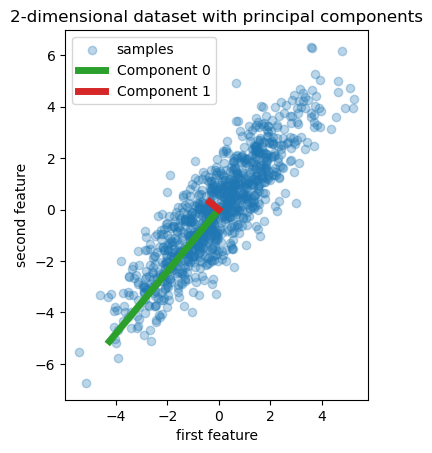

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

rng = np.random.RandomState(1)
n_samples = 1000
cov = [[3, 3], [3, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
pca = PCA(n_components=2).fit(X)

plt.scatter(X[:, 0], X[:, 1], alpha=.3, label='samples')
for i, (comp,var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,
             color=f"C{i + 2}")
plt.gca().set(aspect='equal',
              title="2-dimensional dataset with principal components",
              xlabel='first feature', ylabel='second feature')
plt.legend()
plt.show()

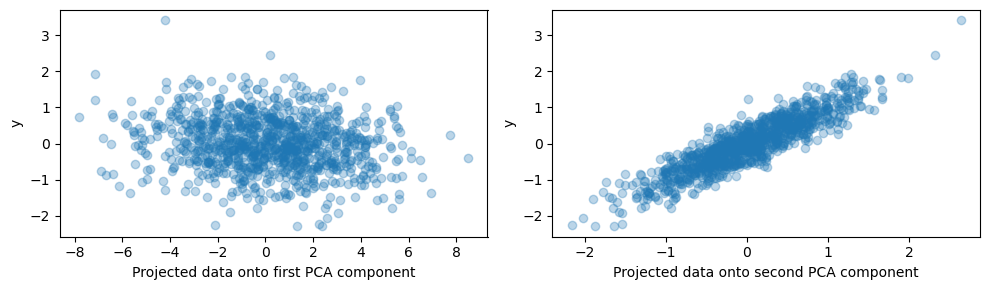

In [2]:
y = X.dot(pca.components_[1] + 0.1 * rng.randn(2)) + 0.3 * rng.randn(n_samples)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(X.dot(pca.components_[0]), y, alpha=.3)
axes[0].set(xlabel="Projected data onto first PCA component",
            ylabel='y')
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=.3)
axes[1].set(xlabel="Projected data onto second PCA component",
            ylabel='y')
fig.tight_layout()
plt.show()

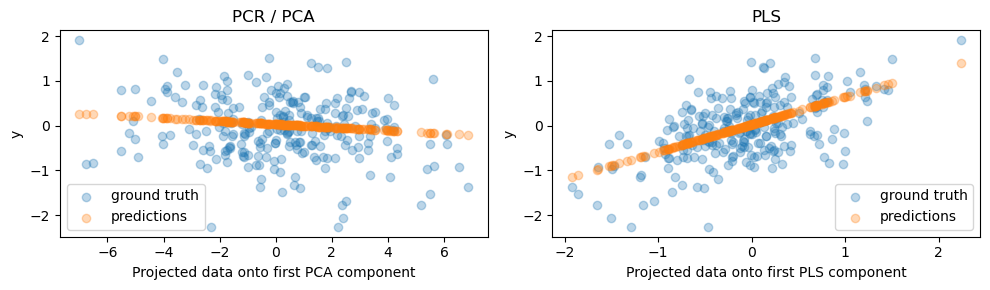

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

pca = pcr.named_steps['pca']  

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test)[:, 0], y_test, alpha=.3, label='ground truth')
axes[0].scatter(pca.transform(X_test)[:, 0], pcr.predict(X_test), alpha=.3,
                label='predictions')
axes[0].set(xlabel='Projected data onto first PCA component',
            ylabel='y', title='PCR / PCA')
axes[0].legend()
axes[1].scatter(pls.transform(X_test)[:, 0], y_test, alpha=.3, label='ground truth')
axes[1].scatter(pls.transform(X_test)[:, 0], pls.predict(X_test), alpha=.3,
                label='predictions')
axes[1].set(xlabel='Projected data onto first PLS component',
            ylabel='y', title='PLS')
axes[1].legend()
fig.tight_layout()
plt.show()

In [14]:
import cvxpy as cp
    
class PLS1():
    def __init__(self, n_components) -> None:
        self.n_components = n_components
    
    def fit(self,X,y):
        n_samples, n_features = X.shape
        # maximize cov(Xw,y) subject to w'w = 1
        W = cp.Variable((n_features, self.n_components))
        C = cp.Variable((1, self.n_components))
        objective = cp.Maximize(cp.trace(X.T @ W @ C.T @ y))
        constraints = [cp.norm(W, 'fro') == 1]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        self.W = W.value
        self.C = C.value
        self.X_mean = np.mean(X,axis=0)
        self.X_std = np.std(X,axis=0)
        self.y_mean = np.mean(y,axis=0)
        self.y_std = np.std(y,axis=0)
        return self
        
    def predict(self,X):
        X_scaled = (X - self.X_mean) / self.X_std
        y_pred = X_scaled @ self.W @ self.C.T * self.y_std + self.y_mean
        return y_pred
    
    def transform(self,X):
        X_scaled = (X - self.X_mean) / self.X_std
        T = X_scaled @ self.W
        return T
    
    def fit_transform(self,X,y):
        self.fit(X,y)
        T = self.transform(X)
        return T
    
    def score(self,X,y):
        y_pred = self.predict(X)
        score = np.mean((y - y_pred)**2)
        return score
    
    def get_params(self,deep=True):
        return {'n_components':self.n_components}
    

In [15]:
pls1 = PLS1(n_components=1)
pls1.fit(X_train,y_train)

ValueError: Incompatible dimensions (2, 750) (2, 1)